# Whole genome nucleotide diversity

In [6]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import functools
from collections import OrderedDict
import timeit

import numpy as np; print('numpy', np.__version__)
import matplotlib as mpl; print('matplotlib', mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd; print('pandas',pd.__version__)
import allel; print('allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

sys.path.append('/home/seoks/Documents/ngs_scripts-master/ngs_py_utils/')
import allel_helpers; print('allel_helpers', allel_helpers.__version__)

from IPython.display import display, HTML

3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
numpy 1.25.1
matplotlib 3.9.2
pandas 2.2.2
allel 1.3.6
zarr 2.15.0
allel_helpers 0.2.1


## Inputs / Constants

In [7]:
INFN_ZARR = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/AalbF5_June2024_DP8_mm0.1.vcf.gz.zarr'

# REGION_FN = 'region_list.xlsx'
META_FN = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/Albo_Pacific.csv'

CHROMS = ['NC_085136.1','NC_085137.1','NC_085138.1']

GROUP_COL = 'Collection_Location'
GROUP_MAX_MISSING_PROPORTION = None

FILTER_SNP = True
FILTER_BIALLELIC = True
FILTER_SINGLETON = True # also filters biallelic
MIN_FMTDP = 8
MAX_MISSING_PROPORTION = 0.1 # applied for set of all samples in meta

RANDOM_SEED = 1
# initializations
np.random.seed(RANDOM_SEED)

In [9]:
POP_GROUPS = [
    'HK', 'HO', 'HM', "IH", 'RMI', 'GU', 'FL', 'CA', 'TH'
]

In [10]:
# load callset
callset = zarr.open_group(INFN_ZARR, mode='r')

# load metadata
"""reads a tsv/csv file into a pandas dataframe
reorders to match order in callset_all_sample_ids
adds 'idx' column
"""
callset_samples = list(callset[list(callset.keys())[0]]['samples'])
sep = ','
header_lines = 0
sample_column_idx = 0
sample_ids_to_drop = 0

meta = pd.read_csv(META_FN, sep=sep, header=header_lines, index_col=sample_column_idx, comment='#')
meta

,Collection_Location
Sample_ID,
Ab15KWAJ001,RMI
Ab15KWAJ002,RMI
Ab15KWAJ003,RMI
Ab15KWAJ004,RMI
Ab18KWAJ001,RMI
...,...
Ae17SGV018,CA
Ae22UHIH001,IH
Ab21BKRA-A002,TH


In [11]:
# Removing samples if requested
if sample_ids_to_drop:
    for s in sample_ids_to_drop: # Drop one at a time so we can tolerate already missing samples
        try:
            meta.drop((s), inplace=True)
        except ValueError as e:
            print('WARNING:', e, file=sys.stderr)
# reorder to match order in callset (callset_all_sample_ids)
meta = meta.reindex([x for x in callset_samples if x in meta.index.values])
sample_ids = meta.index.values
sample_idxs = [callset_samples.index(x) for x in sample_ids]
meta['idx'] = pd.Series(sample_idxs, index=meta.index)


pop_group_results = OrderedDict()
for pop_group in POP_GROUPS:
    print('#'*10,pop_group,'#'*10)
    pop_group_results[pop_group] = OrderedDict()


    # metadata for the subset of samples actually being used
    smeta = pd.concat([ meta.loc[meta[GROUP_COL].isin([pop_group])]])
    smeta['sidx'] = pd.Series(range(len(smeta)), index=smeta.index)
    
    # loading population data
    g_dict = OrderedDict()
    pos_dict = OrderedDict()
    gmeta = None
    for ch in CHROMS:
        print("Chrom:", ch)
        g_dict[ch],pos_dict[ch],meta_out = allel_helpers.LoadRegion(
                    callset, smeta, ch,
                    min_FMTDP=MIN_FMTDP,
                    filter_snp=FILTER_SNP,
                    filter_biallelic=FILTER_BIALLELIC,
                    max_missing_proportion=MAX_MISSING_PROPORTION,
                    group_col=GROUP_COL,
                    group_max_missing_proportion=GROUP_MAX_MISSING_PROPORTION)
        if gmeta is None:
            gmeta = meta_out
        else:
            # ensure meta hasn't changed (it should be the same for all chroms)
            assert gmeta.equals(meta_out)
        
        # make a copy of meta so we don't have to worry about reusing the name
    g_dict_meta = gmeta.copy(deep=True)
    
    # start with clean version of the genotype array and meta based on g_dict
    # combine GenotypeArrays into a single one
    g = g_dict[list(g_dict.keys())[0]].concatenate([g_dict[ch] for ch in list(g_dict.keys())[1:]])
    # copy the meta
    gmeta = g_dict_meta.copy(deep=True)
    
    # create allele counts array for overall population whole genome
    ac1 = g.take(list(smeta.loc[smeta[GROUP_COL].isin([pop_group])]['sidx']), 
             axis=1).count_alleles()
    
    max_alleles =  g.count_alleles()
    pos = range(1,max_alleles.shape[0]+1)
    D1 = allel.sequence_diversity(pos, 
                                  ac1, 
                                  start=None, 
                                  stop=None, 
                                  is_accessible=None)
    # output
    print(pop_group)
    print(list(smeta.loc[smeta[GROUP_COL].isin([pop_group])]['sidx'].index))
    print("num samples per group: {:d}".format(smeta[GROUP_COL].isin([pop_group]).sum()))
    print("{:,d} SNPs for these samples".format(g.shape[0]))
    print("{:.04f} (pi for {:s})".format(D1, pop_group))
    pop_group_results[pop_group]['samples'] = smeta[GROUP_COL].isin([pop_group]).sum()
    pop_group_results[pop_group]['SNPs'] = g.shape[0]
    pop_group_results[pop_group]['pi'] = D1
    
    pi = []
    for ch in g_dict.keys():
        g = g_dict[ch]
        pos = pos_dict[ch]

        ac1 = g.take(list(smeta.loc[smeta[GROUP_COL].isin([pop_group])]['sidx']), 
                     axis=1).count_alleles()

        _pi, windows, n_bases, counts = allel.windowed_diversity(pos, 
                                      ac1, 
                                      size=int(1e6),
                                      start=None, 
                                      stop=None, 
                                      is_accessible=None)
        pi.extend(_pi)

    pop_group_results[pop_group]['windowed_pi'] = pi

########## HK ##########
Chrom: NC_085136.1
Region: NC_085136.1 -> ('NC_085136.1', 1, None)
total number of loci = 2723329
2874146 genotype calls of 21786632 (13.19%) fail FMT:DP filter
= 2582329 passing previous filters & SNP
= 1002755 passing previous filters & biallelic
max missing proportion 0.1 of 8 is 0
max missing passing loci = 1059506 (38.90%)
= 423427 passing previous filters & max_missing
Passing all all filters 423427 of 2723329 (15.55%)
Chrom: NC_085137.1
Region: NC_085137.1 -> ('NC_085137.1', 1, None)
total number of loci = 5236733
5995868 genotype calls of 41893864 (14.31%) fail FMT:DP filter
= 4977278 passing previous filters & SNP
= 1825193 passing previous filters & biallelic
max missing proportion 0.1 of 8 is 0
max missing passing loci = 1865732 (35.63%)
= 727395 passing previous filters & max_missing
Passing all all filters 727395 of 5236733 (13.89%)
Chrom: NC_085138.1
Region: NC_085138.1 -> ('NC_085138.1', 1, None)
total number of loci = 4138699
4702494 genotype ca

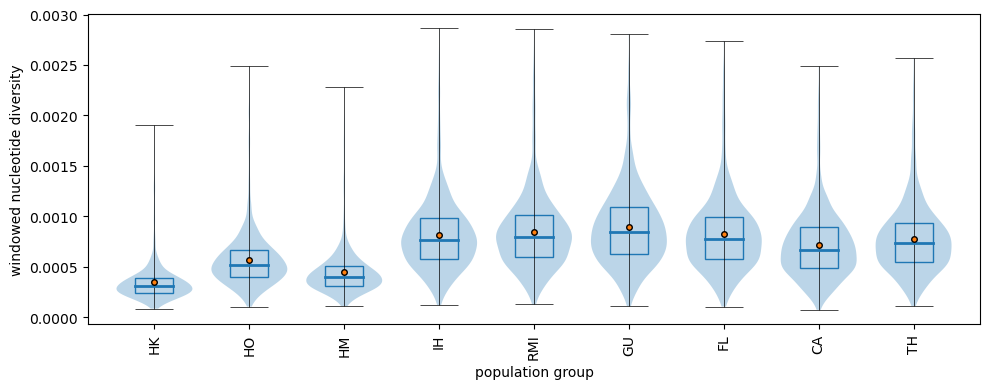

In [13]:
x = []
labs = []
means = []
for group in POP_GROUPS:
    labs.append(group)
    x.append(pop_group_results[group]['windowed_pi'])
    means.append(np.mean(pop_group_results[group]['windowed_pi']))

fig, ax = plt.subplots(1,1, figsize=(10,4))
parts = ax.violinplot(x, 
              points=1000, widths=0.8, bw_method='scott',
              showextrema=True, showmedians=False, showmeans=False)

quartile1, medians, quartile3 = np.percentile(x, [25, 50, 75], axis=1)

inds = np.arange(1, len(medians)+1)
for i, ind in enumerate(inds):
    ax.plot([ind-0.2,ind+0.2],[medians[i],medians[i]], c='C0', lw=2)
    ax.add_patch(mpl.patches.Rectangle((ind-0.2, quartile1[i]), 
                                       0.4, quartile3[i]-quartile1[i],
                                       edgecolor='C0', facecolor='none'))
# plot means
ax.plot(inds, means, markeredgecolor='k', markerfacecolor='C1', 
        marker='o', linestyle='none', markersize=4)

for _ in ['cbars','cmaxes','cmins']:
    parts[_].set_alpha(1)
    parts[_].set_edgecolor('k')
    parts[_].set_linewidth(.5)
# parts['cmaxes'].set_alpha(0)
# parts['cmins'].set_alpha(0)

ax.tick_params(axis='x', labelrotation=90)
ax.set_xticks([y + 1 for y in range(len(labs))])
ax.set_xticklabels(labs);

# tightening up the x axis a bit
# ax.autoscale(enable=True, axis='x', tight=True)
ax.set_xlim([0+0.3,len(labs)+1-0.3]);

ax.set_xlabel("population group")
ax.set_ylabel("windowed nucleotide diversity")
fig.tight_layout()

In [18]:
fig.savefig("Nuleotide_final.svg", facecolor='white')


### Statistical test ###